In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import glob

import pandas as pd
import numpy as np

import seaborn as sns
import matplotlib.pyplot as plt

from gpt_classification import (
    run_gpt_classification,
    gpt_explain_reasoning,
)
from data_functions import balanced_dataset
from shakespeare import comedy_of_errors
from utils import save_dict_of_dfs_with_df_elements, load_dict_of_dfs_with_df_elements

### Plot the distribution of num-words-per-line in Comedy of Errors

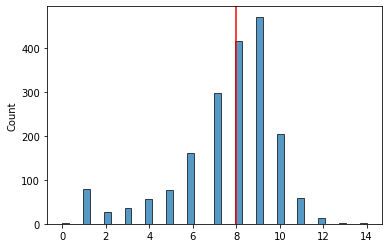

In [28]:
sns.histplot([len(s.split()) for s in comedy_of_errors])
plt.axvline(np.median([len(s.split()) for s in comedy_of_errors]), color='red')
plt.savefig('report/images/comedy-of-errors-lines-wordcount-histogram.png')

### Seems like 5 & 8 are suitable thresholds

In [4]:
experiments = {
    '< 5 #words': "True iff the statement has fewer than 5 words (space-separated)",
    '< 8 #words': "True iff the statement has fewer than 8 words (space-separated)",
    'odd #words': "True iff the statement has an odd number of words (space-separated)",
}

In [5]:
classification_results = {}

In [6]:
test_fns = {
    '< 5 words': lambda s: len(s.split()) < 5,
    '< 8 words': lambda s: len(s.split()) < 8,
    'odd #words': lambda s: len(s.split()) % 2 == 1,
}

In [7]:
def generate_classification_dataset(base_dataset, test_fn, remove_empty_elements=True, is_balanced=True):
    
    if remove_empty_elements:
        base_dataset = [e for e in base_dataset if e]
        
    df = pd.DataFrame(base_dataset, columns=['text'])
    df['label'] = df['text'].apply(test_fn)
    
    if is_balanced:
        df = balanced_dataset(df, test_fn)
    return df

# Less-than-8-words

In [8]:
comedy_of_errors_lt5 = generate_classification_dataset(comedy_of_errors, test_fns['< 5 words'])
comedy_of_errors_lt8 = generate_classification_dataset(comedy_of_errors, test_fns['< 8 words'])
comedy_of_errors_lt8

,text,label
1707,"And, gazing in mine eyes, feeling my pulse,",False
1508,A sin prevailing much in youthful men,True
312,"Say, didst thou speak with him? Know’st thou his",False
1513,You should for that have reprehended him.,True
1542,"In food, in sport, and life-preserving rest",True
...,...,...
971,I’ll stop mine ears against the mermaid’s song.,False
762,"And let us to the Tiger all to dinner,",False
1413,I will discharge thee ere I go from thee.,False
301,"But were we burdened with like weight of pain,",False


In [9]:
# Load the files, if we've run this before, else calculate & save

stem = 'lt8_classification_results'
dataset = comedy_of_errors_lt8

if glob.glob(f'data/{stem}*feather'):
    lt8_classification_results = load_dict_of_dfs_with_df_elements(
        filename_stem=stem,
        models_to_load=['gpt-4']
    )
else:
    lt8_classification_results = run_gpt_classification(
        dataset,
        max_num_examples=100,
    )
    save_dict_of_dfs_with_df_elements(
        lt8_classification_results,
        stem
    )

In [10]:
# Load the files, if we've run this before, else calculate & save

stem = 'lt5_classification_results'
dataset = comedy_of_errors_lt5

if glob.glob(f'data/{stem}*feather'):
    lt5_classification_results = load_dict_of_dfs_with_df_elements(
        filename_stem=stem,
        models_to_load=['gpt-4']
    )
else:
    lt5_classification_results = run_gpt_classification(
        dataset,
        max_num_examples=100,
    )
    save_dict_of_dfs_with_df_elements(
        lt5_classification_results,
        stem
    )

In [11]:
classification_results['< 5 words'] = lt5_classification_results['gpt-4']
classification_results['< 8 words'] = lt8_classification_results['gpt-4']

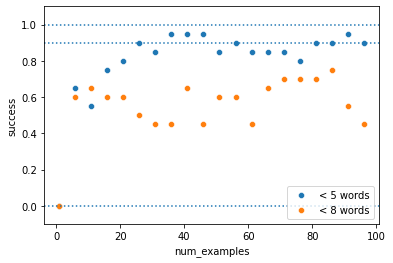

In [31]:
for test, df in classification_results.items():
    sns.scatterplot(data=df, x='num_examples', y='success', label=test)
plt.ylim(-0.1, 1.1)
plt.axhline(0, linestyle=':')
plt.axhline(0.9, linestyle=':')
plt.axhline(1, linestyle=':')

## What does GPT-4 say about the classification rule it's using?

### < 5 words

In [13]:
for num_examples in [20, 35, 40, 80, 100]:
    print('===', num_examples, '===')
    print(gpt_explain_reasoning(
        comedy_of_errors_lt5.sample(n=num_examples, random_state=42)
    ))

=== 20 ===
The classification rule seems to be that sentences or phrases which are incomplete or do not form a cohesive thought are labeled as "True", while complete sentences or phrases forming a complete thought are labeled as "False".
=== 35 ===
The classification rule seems to be that shorter phrases, particularly one or two words or those forming a question are labeled as 'True', while longer sentences or those forming a statement are labeled as 'False'.
=== 40 ===
The classification rule seems to be labelling short phrases or one-word sentences as "True", while longer sentences or more complex structures are labelled as "False".
=== 80 ===
The classification rule seems to be based on the length of the statements. Statements with less than 5 words including punctuation are labeled as "True" while those with 5 words or more are labeled as "False".
=== 100 ===
The classification rule is: If the statement is a question or a one-word phrase, it is labeled as true, and if the statement

### < 8 words

In [14]:
for num_examples in [20, 35, 40, 80, 100]:
    print('===', num_examples, '===')
    print(gpt_explain_reasoning(
        comedy_of_errors_lt8.sample(n=num_examples, random_state=42)
    ))

=== 20 ===
The classification rule seems to be: statements which do not contain a question or a targeted demand/address towards someone are labeled as 'True', while those containing a question or a direct request/order toward someone are labeled as 'False'.
=== 35 ===
The classification rule could be that sentences with terms of address such as 'Master' or sentences that depict a direct speech or conversation are labeled as 'True'. Statements that depict general observations, requests, reflections or are part of a narrative are labeled as 'False'.
=== 40 ===
The classification rule seems to be that sentences with more complex concepts or propositions are labelled as false, while simpler and straightforward sentences are labelled as true. The 'true' statements are also more direct, while the 'false' ones involve more dependent clauses and indirect propositions.
=== 80 ===
The classification rule appears to be based on whether the statement is a question or not. Statements labelled as "T

### < 5 words, with hints

In [15]:
for num_examples in [20, 35, 40, 80, 100]:
    print('===', num_examples, '===')
    print(gpt_explain_reasoning(
        comedy_of_errors_lt5.sample(n=num_examples),
        system_prompt=(
            "You are given some statements, which are labelled with categories. "
            "Describe the classification rule."
            "(Hint: consider the number of words)"
        )
    ))

=== 20 ===
The classification rule is based on the number of words in a statement. Statements with three words or less are labeled as True, whereas statements with four words or more are labeled as False.
=== 35 ===
The classification rule is based on the number of words in each sentence. If a sentence has 4 or fewer words, it is labelled as 'True'. If a sentence has more than 4 words, it is labelled as 'False'.
=== 40 ===
The classification rule is based on the number of words in each statement. If the statement contains 3 words or less it is labeled as True. If it contains more than 3 words, it is labeled as False.
=== 80 ===
The classification rule is based on the number of words in a statement. If a statement has 4 words or less, it's labeled as True, if it has more than 4 words, it's labeled as False.
=== 100 ===
The classification rule is based on the number of words in the sentence. If a sentence contains 3 words or less, it is classified as "True". If a sentence contains more t

### < 8 words, with hints

In [16]:
for num_examples in [20, 35, 40, 80, 100]:
    print('===', num_examples, '===')
    print(gpt_explain_reasoning(
        comedy_of_errors_lt8.sample(n=num_examples),
        system_prompt=(
            "You are given some statements, which are labelled with categories. "
            "Describe the classification rule."
            "(Hint: consider the number of words)"
        )
    ))

=== 20 ===
The classification rule appears to be based on the number of words in each statement. Statements with seven or fewer words are labeled as 'True', while statements with more than seven words are labeled as 'False'.
=== 35 ===
The classification rule is: If a statement has 7 or less words, it's labeled as "True". If it has more than 7 words, it is labeled as "False".
=== 40 ===
The classification rule is based on the number of words in each statement. Statements with five or less words are labelled as "True", while statements with more than five words are labelled as "False".
=== 80 ===
Sentences labelled as "True" have 6 or fewer words, while sentences labelled as "False" have more than 6 words.
=== 100 ===
The classification rule is based on the number of words in each sentence. Statements with 7 words or less are labelled 'True' whereas statements with more than 7 words are labelled 'False'.


# Now do odd#

In [17]:
comedy_of_errors_odd = generate_classification_dataset(comedy_of_errors, test_fns['odd #words'])
comedy_of_errors_odd

,text,label
887,"A very reverend body, ay, such a",True
1256,"Avoid then, fiend! What tell’st thou me of sup...",True
447,that I have.,True
1162,tell.,True
346,Go back again and be new beaten home?,False
...,...,...
1744,Saw’st thou him enter at the abbey here?,False
377,"Would that alone o’ love he would detain,",False
181,"I am invited, sir, to certain merchants,",True
1590,"Yet once again proclaim it publicly,",False


In [18]:
stem = 'oddnum_classification_results'
dataset = comedy_of_errors_odd

if glob.glob(f'data/{stem}*feather'):
    oddnum_classification_results = load_dict_of_dfs_with_df_elements(
        filename_stem=stem,
        models_to_load=['gpt-4']
    )
else:
    oddnum_classification_results = run_gpt_classification(
        dataset,
        max_num_examples=100,
    )
    save_dict_of_dfs_with_df_elements(
        oddnum_classification_results,
        stem
    )

Classifying using: gpt-4


  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

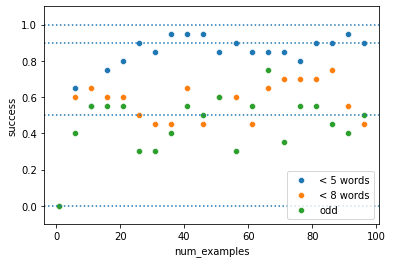

In [30]:
for test, df in classification_results.items():
    sns.scatterplot(data=df, x='num_examples', y='success', label=test)

sns.scatterplot(data=oddnum_classification_results['gpt-4'], x='num_examples', y='success', label='odd')
plt.ylim(-0.1, 1.1)
plt.axhline(0, linestyle=':')
plt.axhline(0.5, linestyle=':')
plt.axhline(0.9, linestyle=':')
plt.axhline(1, linestyle=':')
plt.savefig('report/images/wordcount-classification.png')

In [23]:
for num_examples in [20, 35, 40, 80, 100]:
    print('===', num_examples, '===')
    print(gpt_explain_reasoning(
        comedy_of_errors_odd.sample(n=num_examples),
        system_prompt=(
            "You are given some statements, which are labelled with categories. "
            "Describe the classification rule."
            "(Hint: consider the number of words)"
        )
    ))

=== 20 ===
The classification rule is based on the number of words in each statement. Statements with 9 words are classified as "True", while statements with any other number of words are classified as "False".
=== 35 ===
The classification rule is: statements with odd number of words are labeled "True", whereas statements with even number of words are labeled "False".
=== 40 ===
The classification rule is based on the number of words in each statement. If a statement has 6 words or more, it is labeled as 'True'. If it has less than 6 words, it is labeled as 'False'.
=== 80 ===
The classification rule is based on the number of words in a statement. Statements with 8 or fewer words are labeled as 'True', while statements with more than 8 words are labeled as 'False'.
=== 100 ===
The classification rule is based on the number of words in each sentence. Sentences with 10 or fewer words are labelled as 'True', while sentences with more than 10 words are labelled as 'False'.
